In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from camelyon.data_path import CAMELYON16
from camelyon.datasets import MILDataset
from camelyon.losses import get_pos_weight

train_dataset = MILDataset(
    root_dir=os.path.join("/vast/AI_team/dataset/CAMELYON16/feature/resnet18_10x_h5"),
    device="cuda",
    dry_run=True
)
print(np.unique(train_dataset.bag_h5_paths, return_counts=True))

/home/heon/anaconda3/envs/camelyon/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(array(['/vast/AI_team/dataset/CAMELYON16/feature/resnet18_10x_h5/test/M/test_001.h5',
       '/vast/AI_team/dataset/CAMELYON16/feature/resnet18_10x_h5/test/M/test_002.h5',
       '/vast/AI_team/dataset/CAMELYON16/feature/resnet18_10x_h5/test/M/test_004.h5',
       '/vast/AI_team/dataset/CAMELYON16/feature/resnet18_10x_h5/test/M/test_008.h5',
       '/vast/AI_team/dataset/CAMELYON16/feature/resnet18_10x_h5/test/N/test_003.h5',
       '/vast/AI_team/dataset/CAMELYON16/feature/resnet18_10x_h5/test/N/test_005.h5',
       '/vast/AI_team/dataset/CAMELYON16/feature/resnet18_10x_h5/test/N/test_006.h5',
       '/vast/AI_team/dataset/CAMELYON16/feature/resnet18_10x_h5/test/N/test_007.h5'],
      dtype='<U75'), array([1, 1, 1, 1, 1, 1, 1, 1]))


In [2]:
import os
import torch
from camelyon.data_path import CAMELYON16
from camelyon.datasets import AttentionInductionDataset

dataset = AttentionInductionDataset(
    root_dir="/vast/AI_team/dataset/CAMELYON16/feature/resnet18_10x_h5",
    slide_dir="/vast/AI_team/dataset/CAMELYON16/slide",
    image_dir="/vast/AI_team/dataset/CAMELYON16/patch/10x_h5",
    annotation_dir=os.path.join(CAMELYON16, "annotations"),
    device="cuda:1",
    dry_run=True,
)

/vast/AI_team/dataset/CAMELYON16/slide/test/M/test_001.tif
Attention GT (mean):0.000244140625, max:0.007237718906253576, min:0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Axes: ylabel='Count'>

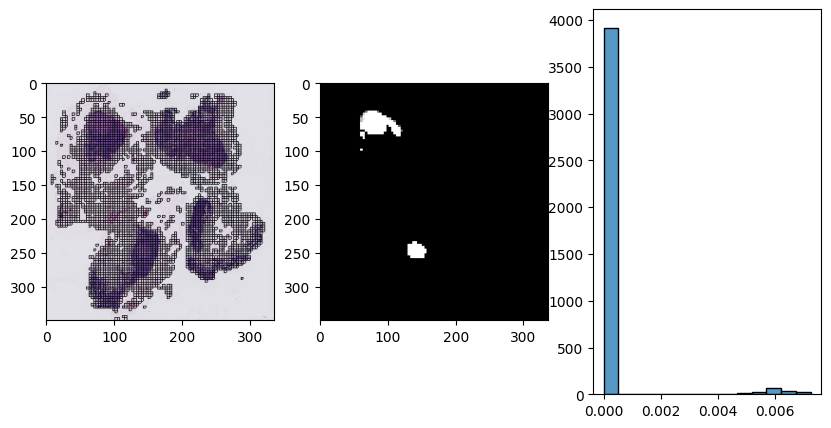

<Figure size 3000x2000 with 0 Axes>

In [3]:
import os
import seaborn as sns
import numpy as np
from openslide import OpenSlide
from openslide.deepzoom import DeepZoomGenerator
from camelyon.misc import get_deepzoom_level
from camelyon.data_models import Patches
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

IDX = 0
MPP = 1.0
LINE_WIDTH = 1
DOWNSAMPLE_RATE = 256


x, y, patch_labels = dataset[IDX]
slide_path = dataset.bag_h5_paths[IDX].replace("/vast/AI_team/dataset/CAMELYON16/feature/resnet18_10x_h5", "/vast/AI_team/dataset/CAMELYON16/slide").replace("h5", "tif")
print(slide_path)
osr = OpenSlide(slide_path)
dgz = DeepZoomGenerator(osr, overlap=0, tile_size=224, limit_bounds=True)
w, h = osr.dimensions

# get_thumbnail() 호출 시에도 (width, height) 순으로
thumbnail_img = osr.get_thumbnail((w // DOWNSAMPLE_RATE, h // DOWNSAMPLE_RATE))
thumbnail = np.array(thumbnail_img)
thumbnail_heatmap = np.zeros_like(thumbnail, dtype=np.float32)

patches = Patches.from_feature_h5(dataset.bag_h5_paths[IDX])
deepzoom_level = get_deepzoom_level(desired_mpp=MPP, slide=osr)
print(f"Attention GT (mean):{patch_labels.mean()}, max:{patch_labels.max()}, min:{patch_labels.min()}")
for i, (patch, patch_label) in enumerate(zip(patches, patch_labels)):
    location, slide_level, size = dgz.get_tile_coordinates(deepzoom_level, patch.address)
    
    x, y = location # at level 0 
    w, h = size
    base_tile_w = w * osr.level_downsamples[slide_level]
    base_tile_h = h * osr.level_downsamples[slide_level]
    
    # 썸네일(1/128) 좌표로 변환
    thumb_x_min = int(x / DOWNSAMPLE_RATE)
    thumb_y_min = int(y / DOWNSAMPLE_RATE)
    thumb_x_max = int((x + base_tile_w) / DOWNSAMPLE_RATE)
    thumb_y_max = int((y + base_tile_h) / DOWNSAMPLE_RATE)
    
    thumbnail_heatmap[thumb_y_min:thumb_y_max, thumb_x_min:thumb_x_max] = patch_label.item()
    
    # 사각형 박스 그리기
    thumbnail[thumb_y_min:thumb_y_max, thumb_x_min:thumb_x_min+LINE_WIDTH, :] = [0, 0, 0]   # 왼쪽
    thumbnail[thumb_y_min:thumb_y_max, thumb_x_max:thumb_x_max+LINE_WIDTH, :] = [0, 0, 0]  # 오른쪽
    thumbnail[thumb_y_min:thumb_y_min+LINE_WIDTH, thumb_x_min:thumb_x_max, :] = [0, 0, 0]  # 위
    thumbnail[thumb_y_max:thumb_y_max+LINE_WIDTH, thumb_x_min:thumb_x_max, :] = [0, 0, 0]  # 아래
    
plt.figure(figsize=(30, 20))
axes[0].imshow(thumbnail)
axes[1].imshow(thumbnail_heatmap*255, vmin=0, vmax=dataset.patch_labels[IDX].max())
sns.histplot(patch_labels.cpu().numpy(), ax=axes[2])

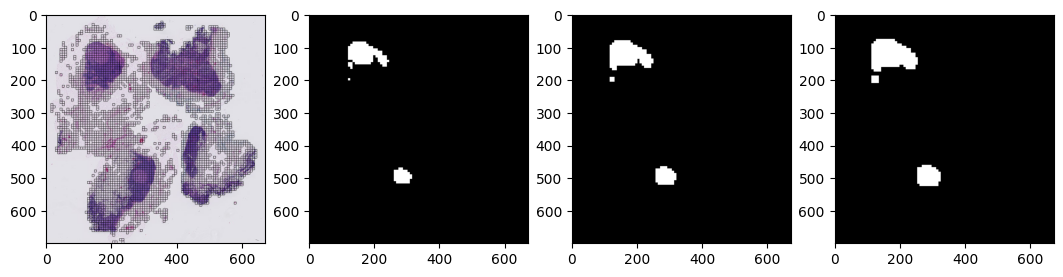

In [13]:
import cv2

fig, axes = plt.subplots(1, 4, figsize=(13, 7))
axes[0].imshow(thumbnail)
axes[1].imshow(thumbnail_heatmap, vmin=0, vmax=dataset.patch_labels[IDX].max())

kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(thumbnail_heatmap, kernel, iterations=2)
axes[2].imshow(dilation, vmin=0, vmax=dataset.patch_labels[IDX].max())

kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(thumbnail_heatmap, kernel, iterations=4)
axes[3].imshow(dilation, vmin=0, vmax=dataset.patch_labels[IDX].max())

In [5]:
axes[0].imshow(thumbnail)
axes[1].imshow(thumbnail_heatmap, vmin=0, vmax=dataset.patch_labels[IDX].max())